# PROJET 5:catégoriser les questions

# Partie 1:  Cleaning et Analyse

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#1)<a class="anchor" id="sommaire"></a>
## [CLEANING ET FEATURE ENGINEERING](#3)<a class="anchor" id="sommaire"></a>
## [ANALYSE DES DONNEES](#4)<a class="anchor" id="sommaire"></a>

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="1"></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import wordcloud
from time import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.test.utils import datapath
from gensim import utils
import gensim.models
import pprint
#from sklearn.multioutput import 
import pickle
from sklearn.multioutput import MultiOutputClassifier
import yake
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss

Téléchargement des dictionnaires nltk

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fried\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fried\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fried\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## [CLEANING ET FEATURE ENGINEERING](#3)<a class="anchor" id="sommaire"></a>

##### Fichier commandes

Tested query: 
SELECT TOP 50000 * 
FROM Posts
WHERE Tags <> '' AND AnswerCount > 0
ORDER BY Score DESC

In [59]:
data=pd.read_csv("stackdbquery.csv")

In [61]:
data.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,11227809,1,11227902.0,NaN,2012-06-27 13:51:36,NaN,24856,1528592,<p>Here is a piece of C++ code that shows some...,87234.0,...,2020-07-16 03:35:56,2020-09-15 02:13:25,Why is processing a sorted array faster than p...,<java><c++><performance><optimization><branch-...,26,2,11113,NaN,NaN,CC BY-SA 4.0
1,927358,1,927386.0,NaN,2009-05-29 18:09:14,NaN,21562,8875014,<p>I accidentally committed the wrong files to...,89904.0,...,2020-09-03 18:36:37,2020-09-03 19:44:51,How do I undo the most recent local commits in...,<git><version-control><git-commit><undo>,86,12,6919,NaN,2013-03-16 10:08:31,CC BY-SA 4.0
2,2003505,1,2003515.0,NaN,2010-01-05 01:12:15,NaN,17273,8363759,<p>I want to delete a branch both locally and ...,95592.0,...,2020-08-06 12:08:14,2020-09-14 04:31:26,How do I delete a Git branch locally and remot...,<git><version-control><git-branch><git-push><g...,40,7,5449,NaN,NaN,CC BY-SA 4.0
3,292357,1,292359.0,NaN,2008-11-15 09:51:09,NaN,12137,2851649,<p>What are the differences between <code>git ...,6068.0,...,2020-06-19 23:18:20,2020-08-01 04:00:48,What is the difference between 'git pull' and ...,<git><version-control><git-pull><git-fetch>,36,10,2375,NaN,NaN,CC BY-SA 4.0
4,231767,1,231855.0,NaN,2008-10-23 22:21:11,NaN,10529,2301696,<p>What is the use of the <code>yield</code> k...,18300.0,...,2020-02-26 21:04:13,2020-08-22 09:50:57,"What does the ""yield"" keyword do?",<python><iterator><generator><yield><coroutine>,42,0,5858,NaN,NaN,CC BY-SA 4.0


In [62]:
len(data.columns)

23

In [66]:
data['Bodyclean']=0
data['Bodyclean']=data['Body']
data['Bodyclean']=data['Bodyclean'].apply(lambda x:BeautifulSoup(x).get_text())
data['Bodyclean']=data['Bodyclean'].apply(lambda x:re.sub(('\d'), '',x))

In [67]:
data['Titleclean']=0
data['Titleclean']=data['Title']
data['Titleclean']=data['Titleclean'].apply(lambda x:BeautifulSoup(x).get_text())
data['Titleclean']=data['Titleclean'].apply(lambda x:re.sub(('\d'), '',x))

In [68]:
data['CleanTags']=0
data['CleanTags']=data['Tags']
data['CleanTags']=data['CleanTags'].apply(lambda x:x.replace('><',' ').replace('<','').replace('>',''))

In [69]:
data['FullClean']=data['Bodyclean']+' '+data['Titleclean']

##### Tokenizing

We will first tokenize our texts using nltk

In [70]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [71]:
from collections import defaultdict

tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats_corporab():
    corporab = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for i in data.index:
        corporab[i] += tokenizer.tokenize(
                                data.loc[i,'FullClean'].lower().replace("'","")
                            )

    stats, freq = dict(), dict()

    for k, v in corporab.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v)} 
        
    return (freq, stats, corporab)

# Récupération des comptages
freq, stats, corporab = freq_stats_corporab()
df = pd.DataFrame.from_dict(stats, orient='index')

# Affichage des fréquences
#df.sort_values(by=['total'], ascending=False)
#df.plot(kind='bar', color="#f56900", title='Top 50 Rappeurs par nombre de mots')



In [72]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus d'artistes
freq_totale = nltk.Counter()
for k, v in corporab.items():
    freq_totale += freq[k]




In [73]:
# creation stopwords avec most common 100
stopwords = freq_totale.most_common(150)

remove relevant word from stopwords

In [74]:
#listing relevant words that are removed:
listereadd=['android','java','c','app','python','html','system','js','javascript','array','version','user']

In [75]:
stopwords=[i[0] for i in stopwords if not i[0] in listereadd]


In [76]:
# On créé notre set de stopwords final qui cumule ainsi les 100 mots les plus fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent dans la librairie NLTK
sw = set()
sw.update(stopwords)
sw.update(range(10))
sw.update(tuple(nltk.corpus.stopwords.words('english')))

In [77]:
data['BodyToken']=data['Bodyclean']
data['BodyToken']=data['BodyToken'].apply(lambda x:tokenizer.tokenize(
                                x.lower().replace("'","").replace('(\d+)', '')))


In [78]:
data['TitleToken']=data['Titleclean']
data['TitleToken']=data['TitleToken'].apply(lambda x:tokenizer.tokenize(
                                x.lower().replace("'","").replace('(\d+)', '')))
data['TitleToken']=data['TitleToken'].apply(lambda x:[len(x)]+[w for w in x])
data['FullToken']=data['TitleToken']+data['BodyToken']
data['FullToken2']=data['FullToken'].apply(lambda x:[x[i] for i in range(1,x[0]) if x[i] not in x[x[0]:len(x)]]+x[x[0]:len(x)])

In [79]:
data['TokenTags']=data['CleanTags']
data['TokenTags']=data['TokenTags'].apply(lambda x:tokenizer.tokenize(x))

In [80]:
data['FullStopWords']=data['FullToken2']
data['FullStopWords']=data['FullStopWords'].apply(lambda x:[w for w in x if not w in list(sw)])

In [81]:
lemmatizer = WordNetLemmatizer() 
data['FullLem']=data['FullStopWords']
data['FullLem']=data['FullLem'].apply(lambda x:[ lemmatizer.lemmatize(w) for w in x])

In [82]:
listecomp=[]
for i in data['FullLem']:
    for j in i:
        listecomp.append(j)
        

In [83]:
listepost=[]
for i in data['FullLem']:
    listepost.append(i)

In [84]:
freq_all = nltk.FreqDist(listecomp)

In [85]:
freq_common=freq_all.most_common(100)

## [ANALYSE DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

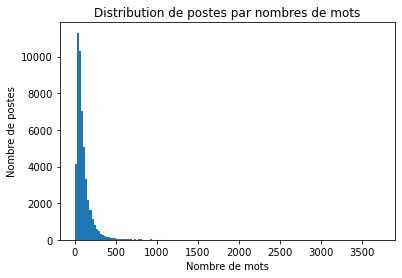

In [105]:
plt.hist(df['total'],bins=150)
plt.title('Distribution de postes par nombres de mots')
plt.ylabel('Nombre de postes')
plt.xlabel('Nombre de mots')
plt.show()

Visualization cloud of most frequent words

In [87]:
from wordcloud import WordCloud

In [88]:
com=defaultdict(list)
for i in freq_common:
    com[i[0]]=i[1]

In [89]:
wc = WordCloud(background_color="white", max_words=100)
    # generate word cloud
wc.generate_from_frequencies(com)

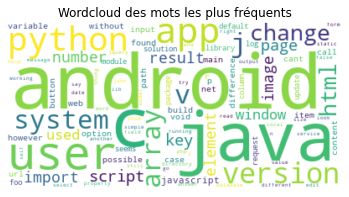

In [90]:
# Display the generated image:
# the matplotlib way:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud des mots les plus fréquents')
plt.show()

Visualization of bigrams

In [91]:
listepost=[]
for i in data['FullLem']:
    for j in range(len(i)):
        if j==0:
            a=i[0]
        else:
            a+=' '+i[j]
    listepost.append(a)

In [92]:
vectorizer = CountVectorizer(ngram_range=(2,2),max_features = 500)
X = vectorizer.fit_transform(listepost)

In [93]:
vocab = vectorizer.get_feature_names()

In [94]:
ldist=[]
dist=X.sum(axis=0)
dist=pd.DataFrame(dist)
for i in range(len(dist.columns)):
    ldist.append(dist.iloc[0,i])

In [95]:
#Create dict
combigram=defaultdict(list)
for i in range(len(vocab)):
    combigram[vocab[i]]=ldist[i]

In [96]:
wc = WordCloud(background_color="white", max_words=100)
    # generate word cloud
wc.generate_from_frequencies(combigram)

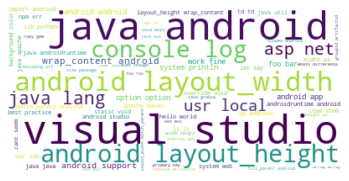

In [97]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Trigram for short

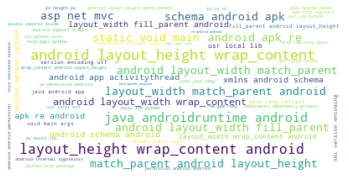

In [98]:
vectorizer = CountVectorizer(ngram_range=(3,3),max_features = 500)
X = vectorizer.fit_transform(listepost)
vocab = vectorizer.get_feature_names()
ldist=[]
dist=X.sum(axis=0)
dist=pd.DataFrame(dist)
for i in range(len(dist.columns)):
    ldist.append(dist.iloc[0,i])
#Create dict
combigram=defaultdict(list)
for i in range(len(vocab)):
    combigram[vocab[i]]=ldist[i]
wc = WordCloud(background_color="white", max_words=100)
    # generate word cloud
wc.generate_from_frequencies(combigram)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Visualization cloud of most frequent tags

In [99]:
listecomptag=[]
for i in data['TokenTags']:
    for j in i:
        listecomptag.append(j)
freq_tag = nltk.FreqDist(listecomptag)
freq_tags=freq_tag.most_common(100)
comtag=defaultdict(list)
for i in freq_tags:
    comtag[i[0]]=i[1]

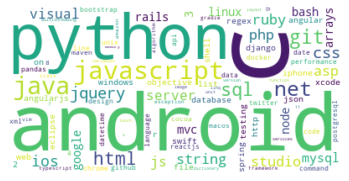

In [100]:
wc1 = WordCloud(background_color="white", max_words=100)
    # generate word cloud
wc1.generate_from_frequencies(comtag)
# Display the generated image:
# the matplotlib way:
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [101]:
#Building a specific data format for future algorithm
def expandlist(x):
    for i in range(len(x)):
        if i==0:
            strx=str(x[i])
        else:
            strx+=' '+str(x[i])
    return strx
data['FullLemExpand']=data['FullLem'].apply(lambda x:expandlist(x))    

In [102]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['FullLemExpand'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])




In [103]:
df2

,unigram,count
0,android,18942
1,java,14930
2,user,10280
3,app,8466
4,python,7680
5,version,7548
6,array,6083
7,change,5938
8,html,5761
9,script,5552


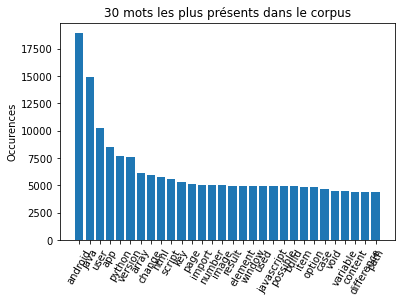

In [104]:
plt.bar(df2['unigram'],df2['count'])
plt.xticks(rotation=60)
plt.ylabel('Occurences')
plt.title('30 mots les plus présents dans le corpus')
plt.show()

In [41]:
data.to_csv('DataNLP.csv')